In [1]:
from scipy.stats import zscore
import pandas as pd
import logging
import os
logging.disable(logging.WARNING)
import torch
import time


from Pytorch_ANN import *
from bayes_opt import BayesianOptimization
import time
from sklearn.model_selection import KFold

'''loading the data'''
all_labels = ['height', 'phi', 'theta', 
        'impact site x', 'impact site y', 'impact site z', 
        'impact site r', 'impact site phi', 'impact site theta']

# Generate some synthetic data for demonstration purposes
# full_dataset_pathname = "/Volumes/Jake_ssd/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
full_dataset_pathname = "/Volumes/Jake_ssd/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
df = pd.read_csv(full_dataset_pathname)
model_types = ['ANN']
labels_to_predict = ['impact site x', 'impact site y', 'height']




In [2]:
all_features_to_keep = {}
backward_feat_selection_results_path = '/Volumes/Jake_ssd/Paper_1_results_WITH_feature_engineering/results'
''' get the features to keep based on the best performing features on test sets in backward feature engineering outputs'''
''' only include more than 10 features though for now. '''
min_features = 1
max_features = 25
for label in labels_to_predict:
    all_features_to_keep[label] = {}
    for model_type in model_types:
        performances = pd.read_csv(backward_feat_selection_results_path + f'/{label}/{model_type}/performances/test_performances.csv')
        #only include rows that have less than 100 features and more than 10 features
        performances = performances.drop(performances[(performances['Unnamed: 0'] < 10) | (performances['Unnamed: 0'] > 100)].index)

        #calculate an average performance across all folds for each feature combination
        performances['average'] = performances[['fold0', 'fold1', 'fold2', 'fold3', 'fold4']].mean(axis=1)
        row_with_largest_average = performances['average'].idxmax() #get the row index that has the best performance across all folds

        #now get the features that were used for the best performing set of features
        features_kept = pd.read_csv(backward_feat_selection_results_path + f'/{label}/{model_type}/performances/features_kept.csv')
        best_feature_combination = features_kept.iloc[row_with_largest_average]['features remaining']
        all_features_to_keep[label][model_type] = ast.literal_eval(best_feature_combination)

|   iter    |  target   |  dropout  | l1_lambda | l2_lambda | learni... |
-------------------------------------------------------------------------
| 1         | 0.4297    | 0.2502    | 0.07203   | 1.144e-05 | 0.0303    |
| 2         | 0.7083    | 0.08805   | 0.009234  | 0.01863   | 0.03462   |
| 3         | 0.1878    | 0.2381    | 0.05388   | 0.04192   | 0.06855   |
| 4         | 0.4308    | 0.1227    | 0.08781   | 0.002739  | 0.06708   |
| 5         | 0.5791    | 0.2504    | 0.05587   | 0.01404   | 0.01989   |
| 6         | 0.1034    | 0.4804    | 0.09683   | 0.03134   | 0.06926   |
| 7         | 0.4004    | 0.5258    | 0.08946   | 0.008504  | 0.004002  |
| 8         | 0.4532    | 0.1019    | 0.08781   | 0.009835  | 0.04217   |
| 9         | 0.204     | 0.5747    | 0.05332   | 0.06919   | 0.03162   |
| 10        | 0.2415    | 0.4119    | 0.08346   | 0.001829  | 0.07504   |
| 11        | 0.6518    | 0.108     | 0.02207   | 0.0       | 0.03043   |
| 12        | 0.6648    | 0.08515   | 

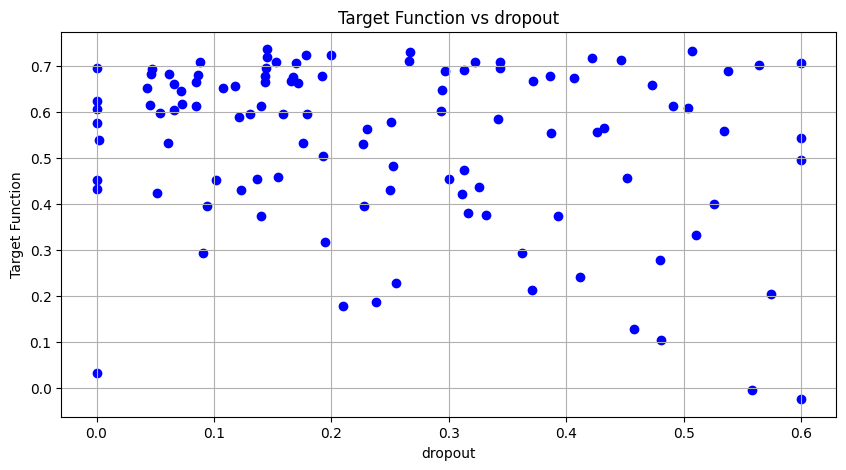

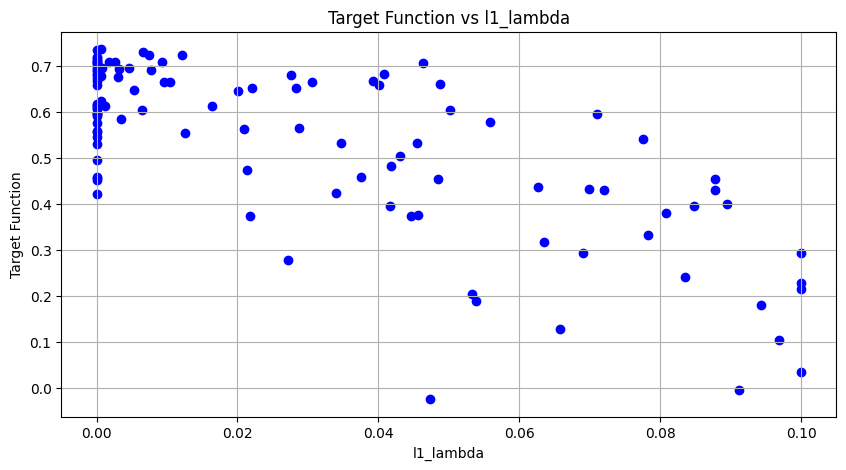

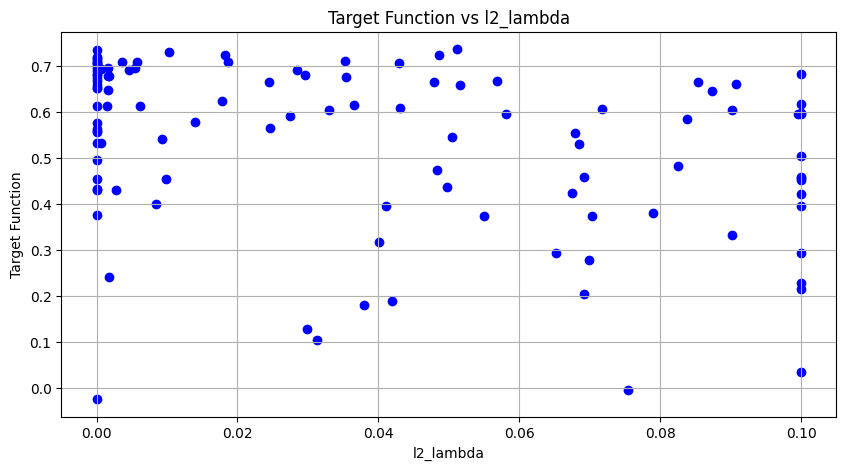

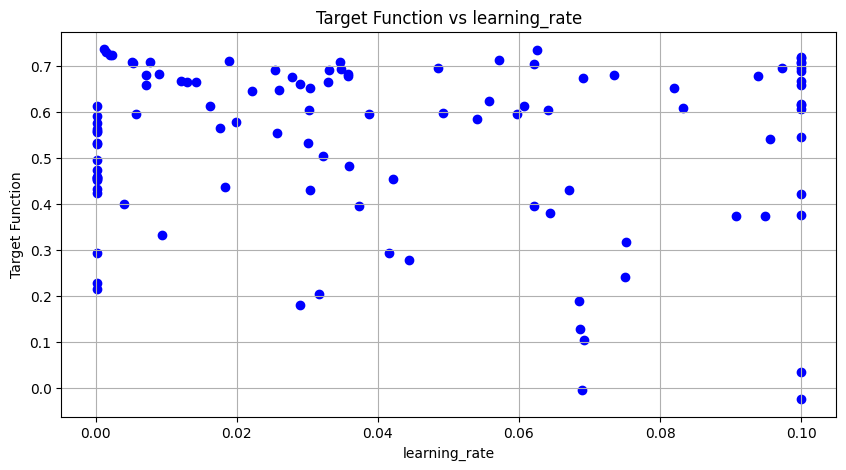

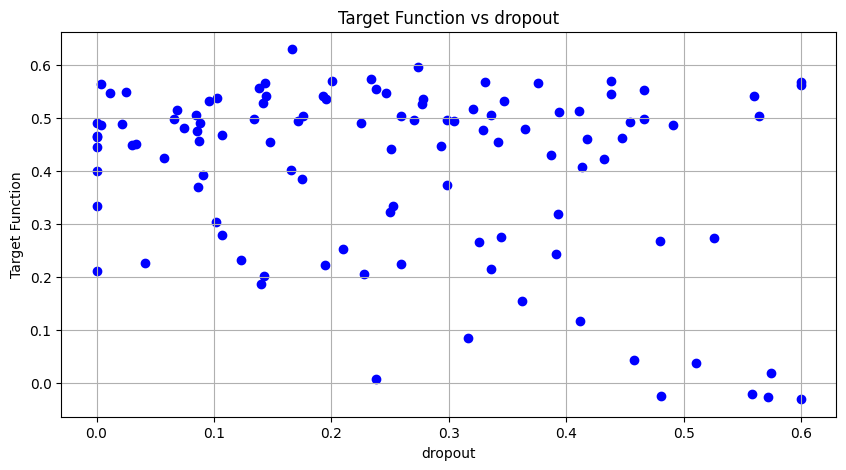

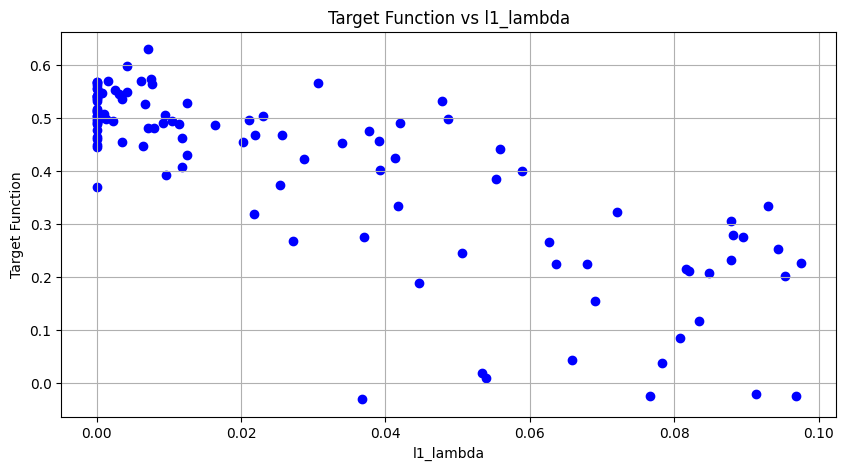

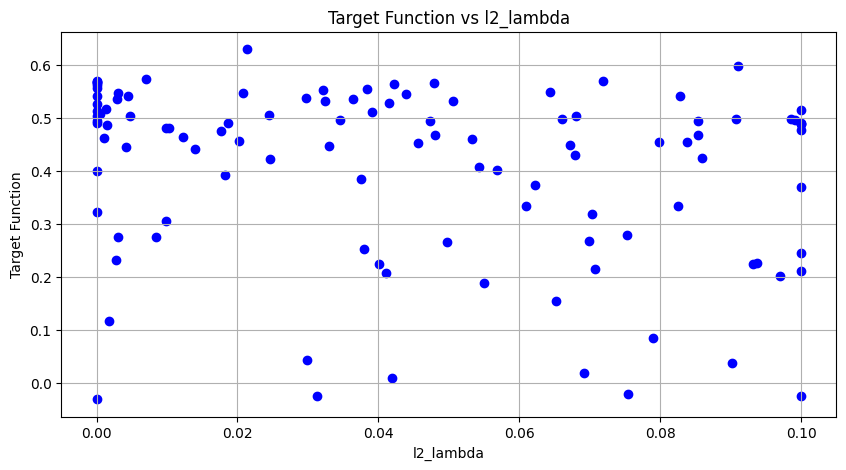

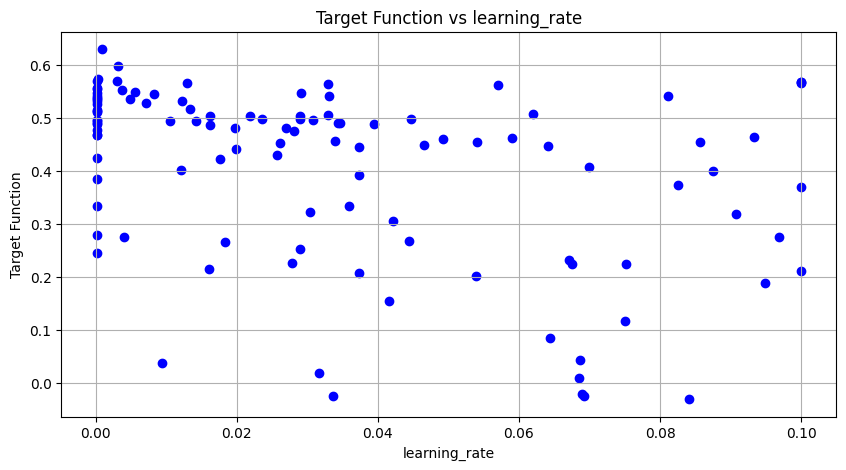

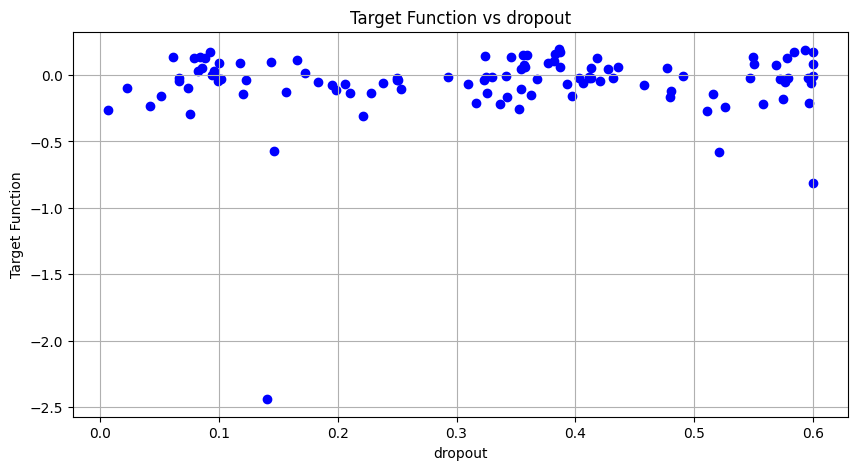

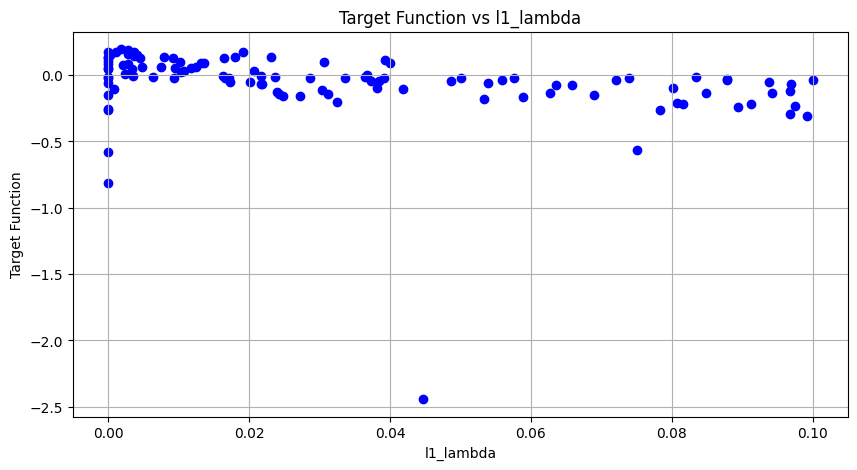

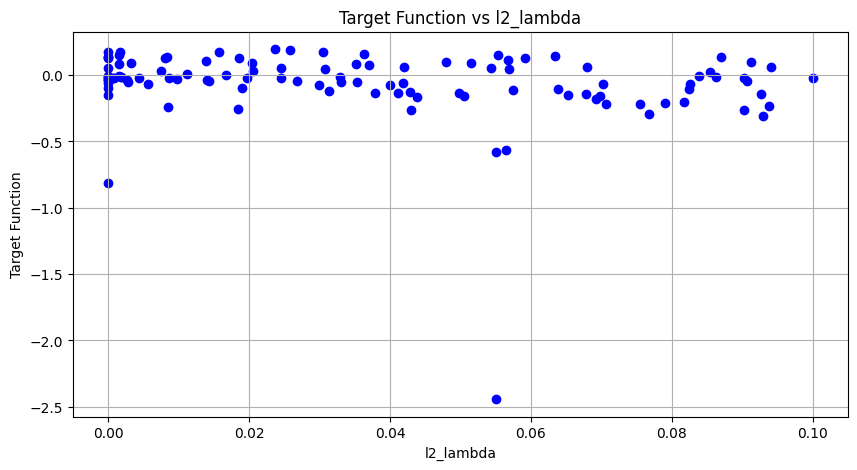

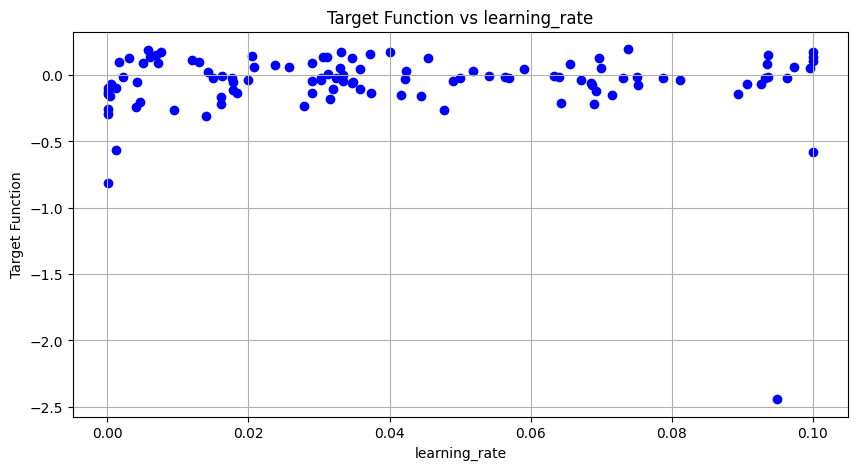

In [3]:


for label in labels_to_predict:
    

    if(df.columns.__contains__('timestep_init')):
        df = df.drop('timestep_init', axis=1)
    if(df.columns.__contains__('Unnamed: 0')):
        df = df.drop('Unnamed: 0', axis=1)

    #TODO make code that selects the best features to keep for this label to predict and replace these lines
    features_to_keep = all_features_to_keep[label]['ANN']
    # if(label == 'height'):
    #     features_to_keep = ['abs_val_sum_kink^2', 'angle_btw^2', 'crack len^2', 'sqrt(max_kink)', 'abs_val_sum_kink (unchanged)', 'max_kink (unchanged)', 'abs_val_mean_kink * avg_ori', 'abs_val_mean_kink * linearity', 'abs_val_sum_kink * crack len', 'abs_val_sum_kink * dist btw frts', 'abs_val_sum_kink * init y', 'abs_val_sum_kink * init z', 'abs_val_sum_kink * max_kink', 'abs_val_sum_kink * mean_kink', 'abs_val_sum_kink * sum_kink', 'angle_btw * init x', 'angle_btw * init y', 'angle_btw * max thickness', 'angle_btw * max_kink', 'angle_btw * median_thickness', 'angle_btw * std_thickness', 'angle_btw * sum_kink', 'angle_btw * var_thickness', 'avg_ori * crack len', 'avg_ori * dist btw frts', 'avg_ori * init z', 'avg_ori * linearity', 'avg_ori * median_kink', 'crack len * init y', 'crack len * max_kink', 'crack len * mean_kink', 'crack len * median_thickness', 'crack len * std_kink', 'crack len * std_thickness', 'crack len * sum_kink', 'dist btw frts * init y', 'dist btw frts * max_kink', 'dist btw frts * mean thickness', 'dist btw frts * mean_kink', 'dist btw frts * median_thickness', 'dist btw frts * std_kink', 'dist btw frts * std_thickness', 'dist btw frts * sum_kink', 'init x * max_kink', 'init y * max thickness', 'init y * max_kink', 'init y * mean_kink', 'init z * max_kink', 'init z * median_kink', 'linearity * max_kink', 'linearity * median_kink', 'max thickness * max_kink', 'max_kink * mean thickness', 'max_kink * std_thickness', 'max_kink * sum_kink', 'mean thickness * std_kink', 'mean_kink * var_thickness', 'median_thickness * std_kink', 'std_thickness * sum_kink', 'sum_kink * var_thickness', 'abs_val_sum_kink / abs_val_mean_kink', 'abs_val_sum_kink / avg_ori', 'abs_val_sum_kink / avg_prop_speed', 'avg_prop_speed / abs_val_sum_kink', 'init x / abs_val_sum_kink', 'abs_val_sum_kink / mean_kink', 'angle_btw / abs_val_mean_kink', 'max_kink / abs_val_mean_kink', 'abs_val_mean_kink ^ -max_prop_speed', 'abs_val_mean_kink + abs_val_sum_kink', 'abs_val_mean_kink + linearity', 'abs_val_mean_kink + median_kink', 'abs_val_sum_kink + angle_btw', 'abs_val_sum_kink + dist btw frts', 'abs_val_sum_kink + init y', 'abs_val_sum_kink + init z', 'abs_val_sum_kink + max_kink', 'abs_val_sum_kink + mean thickness', 'abs_val_sum_kink + median_thickness', 'abs_val_sum_kink + sum_kink', 'angle_btw + avg_ori', 'angle_btw + init x', 'angle_btw + init y', 'angle_btw + init z', 'angle_btw + max_kink', 'angle_btw + mean thickness', 'angle_btw + median_thickness', 'avg_ori + crack len', 'avg_ori + dist btw frts', 'avg_ori + linearity', 'crack len + init y', 'crack len + init z', 'crack len + max_kink', 'crack len + mean thickness', 'crack len + median_thickness', 'crack len + sum_kink', 'dist btw frts + init y', 'dist btw frts + init z', 'dist btw frts + max_kink', 'dist btw frts + mean thickness', 'dist btw frts + median_thickness', 'init y + max thickness', 'init y + max_kink', 'init y + std_kink', 'init y + std_thickness', 'init y + var_kink', 'init y + var_thickness', 'max thickness + max_kink', 'max_kink + var_kink', 'mean thickness + std_kink', 'std_kink + sum_kink', 'abs_val_mean_kink - abs_val_sum_kink', 'abs_val_sum_kink - abs_val_mean_kink', 'abs_val_sum_kink - avg_prop_speed', 'avg_prop_speed - abs_val_sum_kink', 'abs_val_sum_kink - init x', 'init x - abs_val_sum_kink', 'abs_val_sum_kink - linearity', 'linearity - abs_val_sum_kink', 'abs_val_sum_kink - mean_kink', 'mean_kink - abs_val_sum_kink', 'abs_val_sum_kink - median_kink', 'abs_val_sum_kink - std_kink', 'std_kink - abs_val_sum_kink', 'abs_val_sum_kink - thickness_at_init', 'thickness_at_init - abs_val_sum_kink', 'abs_val_sum_kink - var_kink', 'var_kink - abs_val_sum_kink', 'abs_val_sum_kink - var_thickness', 'var_thickness - abs_val_sum_kink', 'angle_btw - abs_val_mean_kink', 'abs_val_mean_kink - angle_btw', 'abs_val_mean_kink - crack len', 'abs_val_mean_kink - dist btw frts', 'init x - abs_val_mean_kink', 'init y - abs_val_mean_kink', 'abs_val_mean_kink - init y', 'max thickness - abs_val_mean_kink', 'abs_val_mean_kink - max thickness', 'max_kink - abs_val_mean_kink', 'abs_val_mean_kink - max_kink', 'std_kink - abs_val_mean_kink', 'abs_val_mean_kink - std_kink', 'var_kink - abs_val_mean_kink', 'abs_val_mean_kink - var_kink', 'var_thickness - abs_val_mean_kink', 'abs_val_mean_kink - var_thickness']
    # elif(label == 'impact site x'):
    #     features_to_keep = ['init x^2', 'init x^3', 'init x * thickness_at_init', 'max_kink * max_prop_speed', 'init y + max thickness', 'init y + mean thickness', 'max thickness + std_kink']
    # elif(label == 'impact site y'):
    #     features_to_keep = ['sqrt(avg_prop_speed)', 'sqrt(init y)', 'abs_val_mean_kink * thickness_at_init', 'avg_ori * linearity', 'crack len * sum_kink', 'init y * mean_kink', 'max_prop_speed * sum_kink', 'abs_val_sum_kink / max_kink', 'max_prop_speed / abs_val_mean_kink']
    #TODO make code that selects the best features to keep for this label to predict and replace these lines
    feature_df = df.drop(all_labels, axis=1)
    feature_df = feature_df[features_to_keep]
    label_df = df[label]



    '''preprocessing the data'''
    # First, zero-center the features by subtracting the mean
    feature_df_centered = feature_df - feature_df.mean()

    # Then, normalize the data to be between -10 and 10 by dividing by the half-range and multiplying by 10
    feature_df_range = (feature_df.max() - feature_df.min()) / 2
    feature_df_normalized = (feature_df_centered / feature_df_range) * 10
    feature_df = feature_df_normalized

    train_feats_df, test_feats_df, train_label_df, test_label_df = train_test_split(
        feature_df, 
        label_df, 
        test_size=0.2,
        random_state=2  # For reproducibility
    )


    x = feature_df.values
    y = label_df.values

    '''Convert data to PyTorch tensors'''
    x_tensor = torch.FloatTensor(x).to(device)
    y_tensor = torch.FloatTensor(y).to(device)

    device = 'cpu'

    saving_folder = f'/Volumes/Jake_ssd/bayesian_optimization/{label}/ANN'
    if(not os.path.exists(saving_folder)): os.makedirs(saving_folder)

    optimizer = do_bayesian_optimization(x_tensor, y_tensor, num_iter=100)
    plot_parameter_trials(optimizer, saving_folder)